## Section 1 : Buisness Understanding

Climate change is a serious and urgent problem for humankind. Stakes are high and we need to stop it. A crucial step is to gain awareness of the problem, the next step is to actively work for improving the situation.

The dataset from the European Social Survey includes responses related to climate change coming from many European countries. Here we will explore these data guided by some questions you have probably already asked yourself.

- Do Europeans actually acknowledge the relevance of climate change?
- Are there some hidden beliefs that might undermine a fast and efficient problem resolution?
- Do European countries have different problems and therefore different directions of improvement?
- Are there apparently unrelated factors that are instead related to climate change beliefs?

## Section 2 : Data Understanding

Let's begin with importing libraries, functions and data needed for the project. 

Note that **the .csv file can be donwloaded for free**, see README.md for more info. 

Additionally, the European Social Survey provided **a very useful .pdf** file where they describe the dataset and the variables in great detailed. I suggest you to take a look and use it as a reference when you want to know more about some variables.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.colors as mcolors
from pycountry_convert import country_alpha2_to_country_name, country_name_to_country_alpha3
from scipy.stats import pearsonr
from weighted_counts import weighted_value_counts,weighted_country_value_counts
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

#color palette
colormap_clmchng = ['#0474BA','#00A7E1', '#FFA630', '#F17720']
colormap_clmchng_r = colormap_clmchng.copy(); colormap_clmchng_r.reverse()
colormap_ccnthum = ['#32c377','#009f95','#0076a3','#004b92','#041c62']
colormap_ccrdprs = ['#c37732', '#c35a32','#bc4742','#af3750','#9c2e5c','#832b65','#672c69','#462c68','#202b62','#101041','#08042a']

#import csv data
df_full = pd.read_csv('./ESS8e02.1_F1.csv',low_memory=False)
df_full.head()

,name,essround,edition,proddate,idno,cntry,nwspol,netusoft,netustm,ppltrst,...,inwsmm,inwdde,inwmme,inwyye,inwehh,inwemm,inwtm,dweight,pspwght,pweight
0,ESS8e02_1,8,2.1,01.12.2018,1,AT,120,4,180,8,...,37,5,12,2016,8,33,50.0,0.611677,1.178496,0.370393
1,ESS8e02_1,8,2.1,01.12.2018,2,AT,120,5,120,6,...,39,25,11,2016,11,10,86.0,1.223354,0.899472,0.370393
2,ESS8e02_1,8,2.1,01.12.2018,4,AT,30,2,6666,5,...,17,22,11,2016,18,0,38.0,0.389058,0.315753,0.370393
3,ESS8e02_1,8,2.1,01.12.2018,6,AT,30,5,120,6,...,9,11,10,2016,19,59,46.0,0.642594,0.472467,0.370393
4,ESS8e02_1,8,2.1,01.12.2018,10,AT,30,5,180,5,...,31,1,12,2016,11,49,70.0,3.432402,2.246706,0.370393


The dataset is huge. We will need only a portion of it.

In [26]:
#select a subset of the dataset
df = df_full[['cntry','pspwght','pweight','clmchng','ccnthum','ccrdprs']]
df.head()

,cntry,pspwght,pweight,clmchng,ccnthum,ccrdprs
0,AT,1.178496,0.370393,1,4,8
1,AT,0.899472,0.370393,1,4,7
2,AT,0.315753,0.370393,1,4,8
3,AT,0.472467,0.370393,2,3,6
4,AT,2.246706,0.370393,1,4,6


Now it we have extracted the variables we are interested in:
- cntry: country
- pspwght: post-stratification weight
- pweight: population weight
- clmchng: World's climate is changing?
- ccnthum: Climate change is caused by nature or human activity?
- ccrdprs: Personal responsibility to try to reduce climate change?

Let's take a general sense of the data.

In [27]:
df.describe()

,pspwght,pweight,clmchng,ccnthum,ccrdprs
count,44387.000000,44387.000000,44387.000000,44387.000000,44387.000000
mean,1.000000,1.174817,1.682024,7.439408,9.490301
std,0.548561,1.301596,1.211252,16.753236,16.570948
min,0.018145,0.030226,1.000000,1.000000,0.000000
25%,0.694870,0.239750,1.000000,3.000000,4.000000
50%,0.920021,0.520820,1.000000,3.000000,6.000000
75%,1.169933,2.013008,2.000000,4.000000,8.000000
max,4.002002,4.985758,9.000000,99.000000,99.000000


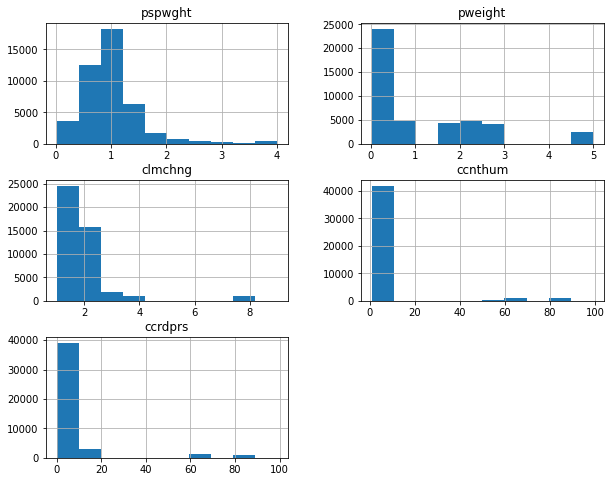

In [28]:
df.hist(figsize=(10,8));

Looking at the counts it seems that the dataset has no missing values.

However, we can notice something strange in the descriptive statistics table and in the histograms: some values are completely out of the distribution of observations.

Now it comes handy the .pdf file. There we can notice that some values are representative of special cases ("Not applicable", "Refusal", "Don't know", "No answer"...). In particular, we are talking about all values >4 for the variable *'clmchng'*, all values >5 for *'ccnthum'*, and all values >10 for *'ccrdprs'*

## Section 3 : Data Preparation

In the previous section we have discovered that there are different special values representing special answers to the survey. Here, for sake of simplicity, we will consider those special values as nulls.

In [29]:
#consider "Not applicable", "Refusal", "Don't know", "No answer" and other answers as missing values 
df['clmchng'].replace(dict.fromkeys([7,8,9],np.NaN),inplace=True) 
df['ccnthum'].replace(dict.fromkeys([55,66,77,88,99],np.NaN),inplace=True)
df['ccrdprs'].replace(dict.fromkeys([66,77,88,99],np.NaN),inplace=True)

Moreover, we need to create a new columns in our dataset combining post-stratification weights and population weights.
Weights are important for survey analysis, because they correct the data avoiding sampling biases and other biases given by the experimental design or by other factors.

In [30]:
#add a new column as the combination between post-stratification weights and population weights
df['anwght'] = df['pspwght'] * df['pweight']

Now the dataset is ready to be used.

In [31]:
df.head()

,cntry,pspwght,pweight,clmchng,ccnthum,ccrdprs,anwght
0,AT,1.178496,0.370393,1.0,4.0,8.0,0.436506
1,AT,0.899472,0.370393,1.0,4.0,7.0,0.333158
2,AT,0.315753,0.370393,1.0,4.0,8.0,0.116953
3,AT,0.472467,0.370393,2.0,3.0,6.0,0.174999
4,AT,2.246706,0.370393,1.0,4.0,6.0,0.832164


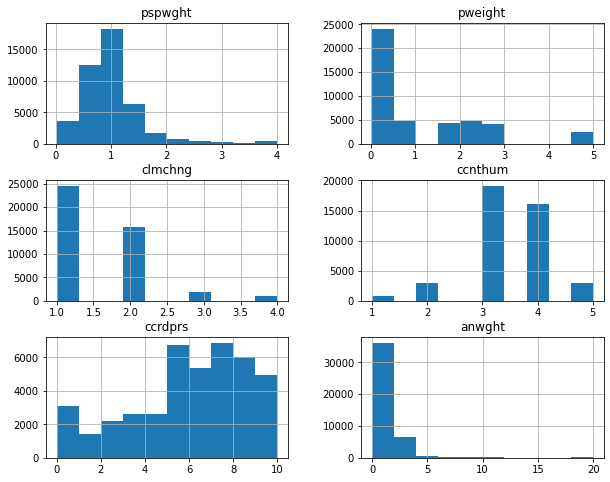

In [32]:
df.hist(figsize=(10,8));

## Section 4 : Evaluation

#### Do Europeans actually acknowledge the relevance of climate change?

To answer let's take a look at the survey question: *Do you think the world's climate is changing?*.
These responses are contained in the column named *'clmchng'*.

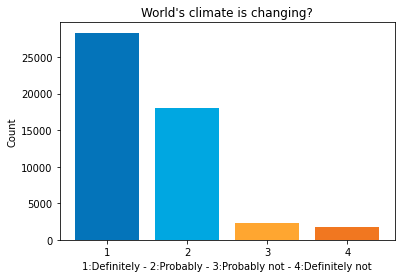

In [34]:
#count the occurrencies of each unique response, weighting each observation
clmchng_w_count = weighted_value_counts(df['clmchng'],df['anwght'])[1:]

#plot a bar chart as an histogram  
plt.bar(sorted(df['clmchng'].unique().astype(int))[1:],clmchng_w_count, color=colormap_clmchng)
plt.title("World's climate is changing?")
plt.ylabel("Count")
plt.xlabel("1:Definitely - 2:Probably - 3:Probably not - 4:Definitely not")
plt.xticks(sorted(df['clmchng'].unique().astype(int))[1:]);

It's clear that the majority of people recognize climate change (blue answers are interpreted as 'Yes' to the survey question). Let's take a look at what this majority means in terms of numbers.

The proportion of people recognizing climate change is: 91.9%


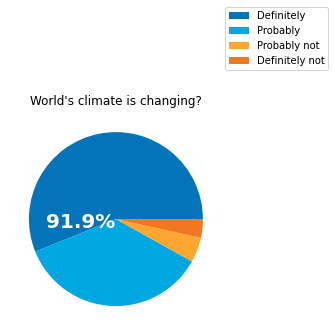

In [40]:
#compute the proportion of 'Definitely or Probably' answers over the total count
clmchng_yes = round(clmchng_w_count[1:2].sum() / clmchng_w_count.sum() *100,1)

#plot a pie chart
plt.pie(clmchng_w_count,colors=colormap_clmchng);
plt.annotate(text=str(clmchng_yes)+"%", xy=(-0.8,-0.1), weight='bold', fontsize=20, color='white');
plt.title("World's climate is changing?");
plt.legend(["Definitely", "Probably" ,"Probably not","Definitely not"], loc='upper right',bbox_to_anchor=(1.5, 1.5));
print("The proportion of people recognizing climate change is: " +str(clmchng_yes)+ "%")

#### Are there some hidden beliefs that might undermine a fast and efficient problem resolution?

It's great that the majority of people recognize climate change. Now, among the precedent group, let's take a look at the survey question: *Do you think that climate change is caused by natural processes, human activity, or both?*.
These responses are contained in the column named *'ccnthum'*.

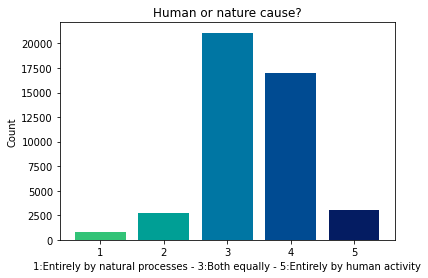

In [41]:
#select the precedent sub-group
df_91_9 = df[df['clmchng'].isin([1,2])]

#count the occurrencies of each unique response, weighting each observation
ccnthum91_9_w_count = weighted_value_counts(df_91_9['ccnthum'],df['anwght']).sort_index().drop(np.NaN)

#plot a bar chart as an histogram  
plt.bar(sorted(df_91_9['ccnthum'].unique().astype(int))[1:],ccnthum91_9_w_count, color=colormap_ccnthum)
plt.title("Human or nature cause?")
plt.ylabel("Count")
plt.xlabel("1:Entirely by natural processes - 3:Both equally - 5:Entirely by human activity")
plt.xticks(sorted(df_91_9['ccnthum'].unique().astype(int))[1:]);

Here the majority of people attribute climate change equally to natural processes and to human activity. The group of people attributing more weight to human activities are more than people attributing more weight to natural activities. Let's take a look at what it means in terms of numbers.

Among the precedent group, the proportion of people recognizing human origins of climate change is: 44.8%


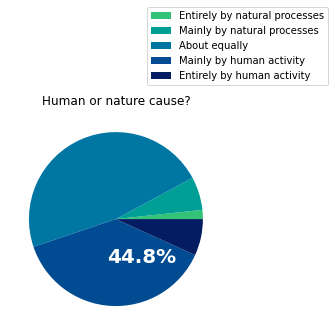

In [42]:
#compute the proportion of 'Entirely or Mainly due to human activities' answers over the total count
ccnthum91_9_yes = round(ccnthum91_9_w_count[4:5].sum() / ccnthum91_9_w_count.sum() *100,1)

#plot a pie chart
plt.pie(ccnthum91_9_w_count,colors=colormap_ccnthum);
plt.annotate(text=str(ccnthum91_9_yes)+"%", xy=(-0.1,-0.5), weight='bold', fontsize=20, color='white');
plt.title("Human or nature cause?");
plt.legend(["Entirely by natural processes", "Mainly by natural processes" ,"About equally","Mainly by human activity", "Entirely by human activity"], loc='upper right',bbox_to_anchor=(1.5, 1.5));
print("Among the precedent group, the proportion of people recognizing human origins of climate change is: " +str(ccnthum91_9_yes)+ "%")

This is not as good as the previous result. Determining causality is a well-known challenge, yet the link between human activities and climate change has been established by the scientific community for a while. Not even half of people are in line with the scientific community.

Now, among the latter group, let's take a look at the survey question: *To what extent do you feel a personal responsibility to try to reduce climate change?*. These responses are contained in the column named *'ccrdprs'*.

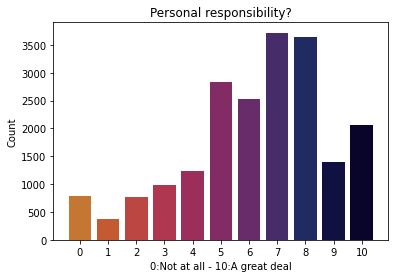

In [43]:
#select the precedent sub-group
df_44_8 = df_91_9[df_91_9['ccnthum'].isin([4,5])]

#count the occurrencies of each unique response, weighting each observation
ccrdprs44_8_w_count = weighted_value_counts(df_44_8['ccrdprs'],df['anwght']).sort_index().drop(np.NaN)

#plot a bar chart as an histogram
plt.bar(sorted(df_44_8['ccrdprs'].unique().astype(int))[1:],ccrdprs44_8_w_count, color=colormap_ccrdprs)
plt.title("Personal responsibility?")
plt.ylabel("Count")
plt.xlabel("0:Not at all - 10:A great deal")
plt.xticks(sorted(df_44_8['ccrdprs'].unique().astype(int))[1:]);

Here the responses are much more distributed across all the values. This distribution seems to be shifted toward the right (feeling personal responsibility), yet we are looking at a totally different story from the first question in terms of consensus. Let's look the proportion of people that depart more from the center of the distribution.

Among the precedent group, the proportion of people feeling a personal responsibility to try to reduce climate change is: 53.2%


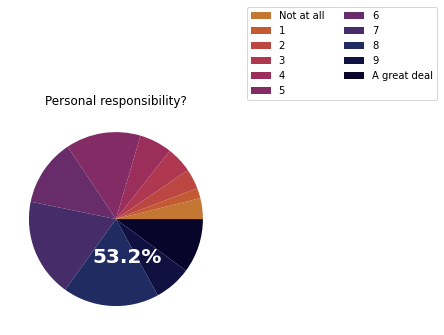

In [44]:
#compute the proportion of '>6' answers over the total count
ccrdprs44_8_yes = round(ccrdprs44_8_w_count[7:10].sum() / ccrdprs44_8_w_count.sum() *100,1)

#plot a pie chart
plt.pie(ccrdprs44_8_w_count,colors=colormap_ccrdprs);
plt.annotate(text=str(ccrdprs44_8_yes)+"%", xy=(-0.27,-0.5), weight='bold', fontsize=20, color='white');
plt.title("Personal responsibility?");
plt.legend(["Not at all", "1","2" ,"3","4", "5", "6", "7", "8", "9", "A great deal"], loc='upper right',bbox_to_anchor=(2, 1.5), ncol=2);
print("Among the precedent group, the proportion of people feeling a personal responsibility to try to reduce climate change is: " +str(ccrdprs44_8_yes)+ "%")

This is the most unhappy result. Half of the individuals who recognize the dramatic situation of climate change as a phenomenon mainly caused by human activities do not feel that their own actions matter.

**Coming back to the question**, it seems that there are other factors than the mere "I believe climate change exists" that could potentially undermine a fast and efficient problem resolution. Failing to attribute climate change to human activities and failing to feeling a personal responsibility about it could lead to a passive observation of the situation, without any will to act upon in, trying to work on solutions and improvements.

#### Do European countries have different problems and therefore different directions of improvement?

Is the same everywhere? The available data provide information regarding the country of residence of respondents. For each of the three survey questions analyzed before, we can now look how the same proportions are distributed geographically across Europeans countries.

In [45]:
#count the values separately for each country (now the population weight is not useful anymore)
clmchng_weighted_count = weighted_country_value_counts(df['cntry'],df['clmchng'],df['pspwght']).drop(np.NaN).sort_index()

#select the sub-group of 'Definitely or Probably' in the first question
df_yes_clmchng = df[df['clmchng'].isin([1,2])]

#count the values separately for each country
ccnthum_weighted_count = weighted_country_value_counts(df_yes_clmchng['cntry'],df_yes_clmchng['ccnthum'],df_yes_clmchng['pspwght']).drop(np.NaN).sort_index()

#select the sub-group of 'Entirely or Mainly due to human activities' in the second question
df_yes_ccnthum = df_yes_clmchng[df_yes_clmchng['ccnthum'].isin([4,5])]

#count the values separately for each country
ccrdprs_weighted_count = weighted_country_value_counts(df_yes_ccnthum['cntry'],df_yes_ccnthum['ccrdprs'],df_yes_ccnthum['pspwght']).drop(np.NaN).sort_index()

Let's take a look at the first question.

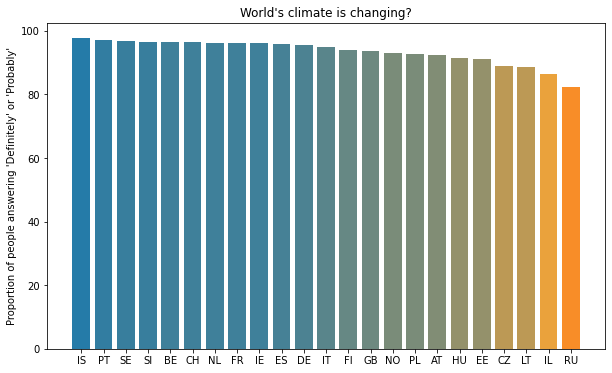

In [49]:
#compute the proportion of people recognizing climate change in each country
clmchng_yes_countries = []
for c,country in enumerate(df['cntry'].unique()):
    c_w_count = clmchng_weighted_count[country]
    clmchng_yes_countries.append(round(c_w_count[1:2].sum() / c_w_count.sum() *100,1))

#create a continuous colormap from previous discrete colormap
colormap_clmchng = ['#0474BA','#00A7E1', '#FFA630', '#F17720']
clist = [(0, colormap_clmchng[3]), (0.8, colormap_clmchng[3]), (0.85,colormap_clmchng[2]),(1, colormap_clmchng[0])]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

#order countries in descending order
sort_id = np.argsort(-np.array(clmchng_yes_countries))

#plot bar chart
plt.figure(figsize=(10,6))
plt.bar(df['cntry'].unique()[sort_id],sorted(clmchng_yes_countries, reverse=True), color=rvb(np.array(sorted(clmchng_yes_countries, reverse=True))/100));
plt.title("World's climate is changing?")
plt.ylabel("Proportion of people answering 'Definitely' or 'Probably'");

All countries seems to have quite high proportions of positive answers at this questions, consistently with previous results.

What about the second question?

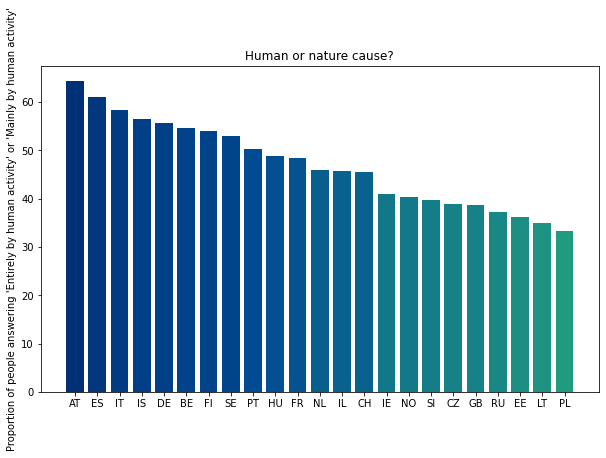

In [50]:
#compute the proportion of people recognizing human origins of climate change
ccnthum_yes_countries = []
for c,country in enumerate(df_yes_clmchng['cntry'].unique()):
    c_w_count = ccnthum_weighted_count[country]
    ccnthum_yes_countries.append(round(c_w_count[4:5].sum() / c_w_count.sum() *100,1))

#create a continuous colormap from previous discrete colormap
clist = [(0, colormap_ccnthum[0]), (0.25, colormap_ccnthum[0]), (0.50, colormap_ccnthum[3]),(0.75,colormap_ccnthum[4]),(1, colormap_ccnthum[4])]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

#order countries in descending order
sort_id = np.argsort(-np.array(ccnthum_yes_countries))

#plot bar chart
plt.figure(figsize=(10,6))
plt.bar(df_yes_clmchng['cntry'].unique()[sort_id],sorted(ccnthum_yes_countries, reverse=True), color=rvb(np.array(sorted(ccnthum_yes_countries, reverse=True))/100));
plt.title("Human or nature cause?")
plt.ylabel("Proportion of people answering 'Entirely by human activity' or 'Mainly by human activity'");

Here the proportions of human cause recognition are much more diverse and lower than before.

What about the third question?

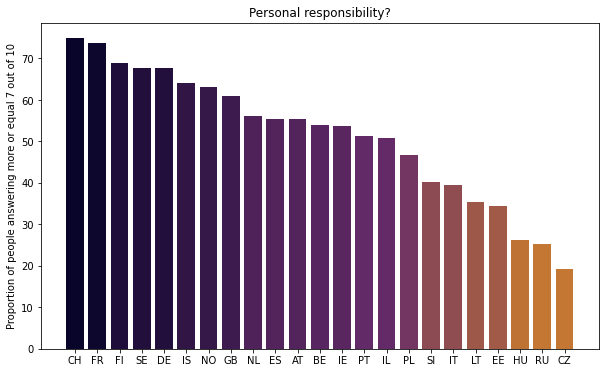

In [51]:
#compute the proportion of people feeling a personal responsibility to try to reduce climate change
ccrdprs_yes_countries = []
for c,country in enumerate(df_yes_ccnthum['cntry'].unique()):
    c_w_count = ccrdprs_weighted_count[country]
    ccrdprs_yes_countries.append(round(c_w_count[7:].sum() / c_w_count.sum() *100,1))

#create a continuous colormap from previous discrete colormap
clist = [(0, colormap_ccrdprs[0]), (0.25, colormap_ccrdprs[0]), (0.50, colormap_ccrdprs[6]),(0.75,colormap_ccrdprs[10]),(1, colormap_ccrdprs[10])]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

#order countries in descending order
sort_id = np.argsort(-np.array(ccrdprs_yes_countries))

#plot bar chart
plt.figure(figsize=(10,6))
plt.bar(df_yes_ccnthum['cntry'].unique()[sort_id],sorted(ccrdprs_yes_countries, reverse=True), color=rvb(np.array(sorted(ccrdprs_yes_countries, reverse=True))/100));
plt.title("Personal responsibility?");
plt.ylabel("Proportion of people answering more or equal 7 out of 10");

The proportions of people feeling a personal responsibility are the most diverse. In same countries this proportion reaches more than 70% of people, while in other it drops below 20%.

These visualizations are useful to understand the serial order of the countries. However, we are spatially oriented animals, and a geographic visualization can help us better understand these countries differences.

Let's prepare a dataframe for this purpose.

In [52]:
#build a dataframe where for each country it is stored the proportion of "yes" to the three initial questions.
yes_map = pd.DataFrame({'cntry':df['cntry'].unique(),'clmchng_yes':clmchng_yes_countries, 'ccnthum_yes':ccnthum_yes_countries, 'ccrdprs_yes':ccrdprs_yes_countries})

#convert country codes from 2 letters to 3 letters (necessary for plotly)
yes_map['country_alpha_3'] = yes_map.cntry.apply(lambda x: country_name_to_country_alpha3(country_alpha2_to_country_name(x)))
yes_map

,cntry,clmchng_yes,ccnthum_yes,ccrdprs_yes,country_alpha_3
0,AT,92.5,64.3,55.3,AUT
1,BE,96.4,54.6,54.0,BEL
2,CH,96.4,45.5,74.9,CHE
3,CZ,88.9,38.8,19.2,CZE
4,DE,95.5,55.6,67.6,DEU
5,EE,91.3,36.1,34.4,EST
6,ES,95.8,61.0,55.4,ESP
7,FI,94.0,54.1,68.9,FIN
8,FR,96.3,48.4,73.7,FRA
9,GB,93.6,38.7,60.9,GBR


We have now a dataframe ready to be plotted!

In [62]:
#plot a map with the proportion of people recognizing climate change in each country as a colorcode
fig = px.choropleth(yes_map, locationmode= 'ISO-3',locations='country_alpha_3', color='clmchng_yes', projection='natural earth'
, color_continuous_scale=colormap_clmchng_r, title="World's climate is changing?", width=900, height=600)
fig.update_geos(center=dict(lon=10, lat=55),
    lataxis_range=[0,55], lonaxis_range=[0, 80])
fig.show()

People recognition of climate change is quite high in the hole Western Europe.

In [67]:
#plot a map with the proportion of people recognizing human origins of climate change in each country as a colorcode
fig = px.choropleth(yes_map, locationmode= 'ISO-3',locations='country_alpha_3', color='ccnthum_yes', projection='natural earth'
, color_continuous_scale=colormap_ccnthum, title="Human or nature cause?", width=900, height=600)
fig.update_geos(center=dict(lon=10, lat=55),
    lataxis_range=[0,55], lonaxis_range=[0, 80])
fig.show()

Regarding the beliefs on the origin of climate change, countries in the Meridional and Central Europe tend to attribute more weight to human activities relative to Northen and Eastern Europe.

In [68]:
#plot a map with the proportion of people feeling a personal responsibility to try to reduce climate change in each country as a colorcode
fig = px.choropleth(yes_map, locationmode= 'ISO-3',locations='country_alpha_3', color='ccrdprs_yes', projection='natural earth'
, color_continuous_scale=colormap_ccrdprs, title="Personal responsibility?", width=900, height=600)
fig.update_geos(center=dict(lon=10, lat=55),
    lataxis_range=[0,55], lonaxis_range=[0, 80])
fig.show()

The geographical distribution of the scores regarding the feelings of personal responsibilities is more diverse. With lower scores for the South-East Europe, and higher scores for the North-West Europe.

So each country has a particular combination of high and low scores. Looking at a country lowest score could serve as a hint to know in which domain could be improved.

Anyway, these are single-countries considerations. What if we want to understand if there is a more general relationship between those 3 questions? One way to test for this is looking for correlations.

In [70]:
#compute pearson correlations
corr_ch = pearsonr(yes_map['clmchng_yes'],yes_map['ccnthum_yes'])
corr_hr = pearsonr(yes_map['ccnthum_yes'],yes_map['ccrdprs_yes'])

#store correlation r
ch_r = round(corr_ch[0],2)
hr_r = round(corr_hr[0],2)

print(f"Change-Human correlation: R={ch_r}, p_value={round(corr_ch[1],2)}")
print(f"Human-Responsibility correlation: R={hr_r}, p_value={round(corr_hr[1],2)}")

Change-Human correlation: R=0.46, p_value=0.03
Human-Responsibility correlation: R=0.42, p_value=0.05


To better understand what it means, let's plot these results.

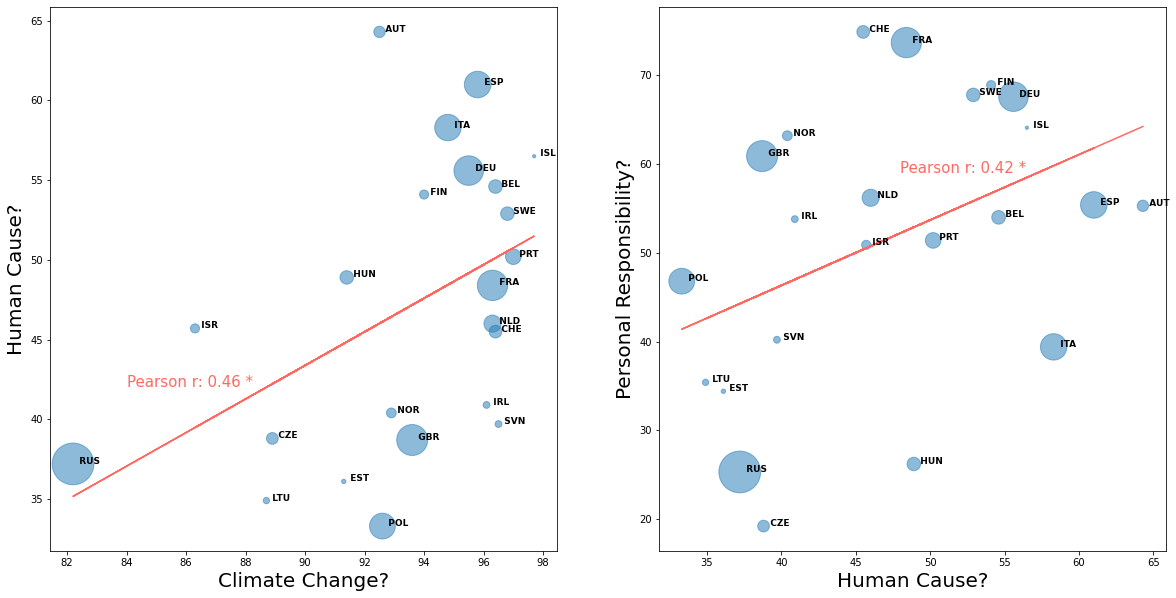

In [71]:
#extract array with a measure of the population size of each country
cntry_size = df[['cntry','pweight']].groupby('cntry').mean()

#build a scatter plot with regressions lines
fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].scatter(yes_map['clmchng_yes'],yes_map['ccnthum_yes'], s=cntry_size['pweight']*350, alpha=0.5); axs[0].set_xlabel("Climate Change?", fontsize=20); axs[0].set_ylabel("Human Cause?", fontsize=20); m, b = np.polyfit(yes_map['clmchng_yes'],yes_map['ccnthum_yes'], 1); axs[0].plot(yes_map['clmchng_yes'], m*yes_map['clmchng_yes'] + b, color='#FF6962'); axs[0].annotate("Pearson r: " + str(ch_r) + " *", (84,42), color='#FF6962', fontsize=15);
axs[1].scatter(yes_map['ccnthum_yes'],yes_map['ccrdprs_yes'], s=cntry_size['pweight']*350, alpha=0.5); axs[1].set_xlabel("Human Cause?", fontsize=20); axs[1].set_ylabel("Personal Responsibility?", fontsize=20); m, b = np.polyfit(yes_map['ccnthum_yes'],yes_map['ccrdprs_yes'], 1); axs[1].plot(yes_map['ccnthum_yes'], m*yes_map['ccnthum_yes'] + b, color='#FF6962'); axs[1].annotate("Pearson r: " + str(hr_r) + " *", (48,59), color='#FF6962', fontsize=15);
for i,txt in enumerate(yes_map['country_alpha_3']):
    axs[0].annotate("  " +str(txt), (yes_map['clmchng_yes'][i],yes_map['ccnthum_yes'][i]), size=9, weight='bold')
    axs[1].annotate("  " +str(txt), (yes_map['ccnthum_yes'][i],yes_map['ccrdprs_yes'][i]), size=9, weight='bold')

There is a significant correlation between the proportion of people living in a country recognizing climate change and the proportion of people in the same country ascribing climate change to human activities.

A significant correlation is also found between the proportion of people ascribing climate change to human activities and the proportion of people in the same country feeling a personal responsibility to try to reduce climate change.

So, despite the individual differences, this general trend could suggest that increasing any of these scores might benefit also the other scores. 

*(Note: correlation doens't mean causation. So it is possible that there is a common hidden variable that is modulating our three variables of interest.)*

### BONUS: Are there apparently unrelated factors that are instead related to climate change beliefs?

To test this, we will use a statistical model.

In [75]:
from sklearn.model_selection import train_test_split
from statsmodels.miscmodels.ordinal_model import OrderedModel

Let's build a new dataset with the variables we are now investigating: the previous three variables + # years of age, # education years, # minutes of internet usage per day, # minutes on political news per day, # working hours per week.

Just as before we will consider those special values as nulls.

In [72]:
#Extract a new sub-set of the full dataset
df_reg = df_full[['clmchng','ccnthum','ccrdprs','agea','eduyrs','netustm','nwspol','wkhct']]

#consider "Not applicable", "Refusal", "Don't know", "No answer" and other answers as missing values 
df_reg['clmchng'].replace(dict.fromkeys([7,8,9],np.NaN),inplace=True) 
df_reg['ccnthum'].replace(dict.fromkeys([55,66,77,88,99],np.NaN),inplace=True)
df_reg['ccrdprs'].replace(dict.fromkeys([66,77,88,99],np.NaN),inplace=True)
df_reg['agea'].replace(999,np.NaN,inplace=True)
df_reg['eduyrs'].replace(dict.fromkeys([77,88,99],np.NaN),inplace=True)
df_reg['netustm'].replace(dict.fromkeys([6666,7777,8888,9999],np.NaN),inplace=True)
df_reg['nwspol'].replace(dict.fromkeys([7777,8888,9999],np.NaN),inplace=True)
df_reg['wkhct'].replace(dict.fromkeys([666,777,888,999],np.NaN),inplace=True)

df_reg.head()

,clmchng,ccnthum,ccrdprs,agea,eduyrs,netustm,nwspol,wkhct
0,1.0,4.0,8.0,34.0,21.0,180.0,120.0,25.0
1,1.0,4.0,7.0,52.0,16.0,120.0,120.0,NaN
2,1.0,4.0,8.0,68.0,13.0,NaN,30.0,38.0
3,2.0,3.0,6.0,54.0,12.0,120.0,30.0,40.0
4,1.0,4.0,6.0,20.0,13.0,180.0,30.0,40.0


We will use our three initial questions on climate change as dependent variables, one at a time. So now we differenciate data in three dataframes, each one having all the values of the respective variable as valid scores (removing nans).

In [73]:
#define dataframe where rows containing nans in the 'clmchng' columns are dropped
df_reg_cc = df_reg.dropna(subset=['clmchng'],axis=0)
#reverse the scores to be coherent with the other two questions: higher score means more recognition to climate change
df_reg_cc['clmchng'] = -df_reg_cc['clmchng']

#define dataframe where rows containing nans in the 'ccnthum' columns are dropped
df_reg_ch = df_reg.dropna(subset=['ccnthum'],axis=0)

#define dataframe where rows containing nans in the 'ccrdprs' columns are dropped
df_reg_pr = df_reg.dropna(subset=['ccrdprs'],axis=0)

We have data ready to fit three different Ordinal Logistic Regression models, one with each climate change question as dependent variable.

Note that we do not use a simple Linear Regression model here because our climate change variables are ordinal.

Optimization terminated successfully.
         Current function value: 0.911958
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 1.164544
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 2.256977
         Iterations: 40
         Function evaluations: 46
         Gradient evaluations: 46


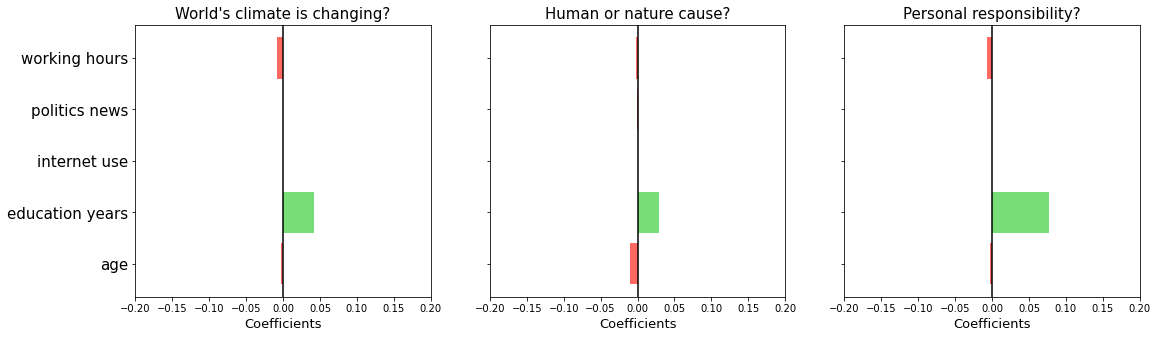

In [80]:
#build a subplot structure
fig, axs = plt.subplots(1,3,figsize=(18,5))
#define lists used in the loop
df_list = [df_reg_cc,df_reg_ch,df_reg_pr]
y_list = ['clmchng','ccnthum','ccrdprs']
title_list = ["World's climate is changing?","Human or nature cause?","Personal responsibility?"]

for d,df_plotted in enumerate(df_list):

    #define the predictor matrix X containing 5 variables: 'age', 'education years', 'internet use', 'politics news', 'working hours'
    X = df_plotted.drop(columns=['clmchng','ccnthum','ccrdprs'])
    X = X.apply(lambda col: col.fillna(col.mean()))

    #define the dependent variable as one of the variable of interest
    y = df_plotted[y_list[d]]

    #split in train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

    #initialize and fit the ordered logistic model
    mod_prob = OrderedModel(y_train,X_train, distr='logit')
    res_prob_pr = mod_prob.fit(method='bfgs')

    #define how many predictors 
    n_ind_vars = 5

    #extract coefficients from summary table
    summary_m = res_prob_pr.summary()
    tcoeff = summary_m.tables[1]
    coeffs = []
    for row in tcoeff.data:
        coeffs.append(row[1])

    #convert coefficients into a numpy array
    coeff_array = np.array(coeffs)[1:n_ind_vars+1].astype(float)

    #define colors relative to the positive coff (green) or negative coeff (red)
    col_bars = []
    for col in coeff_array:
        if col >0:
            col_bars.append("#77DD76")
        else:
            col_bars.append("#FF6962")

    #plot three horizontal bar charts
    axs[d].barh(y=list(range(len(coeff_array))), width=coeff_array, color=col_bars)
    axs[d].set_yticks(range(n_ind_vars))
    if d == 0:
        axs[d].set_yticklabels(['age', 'education years', 'internet use', 'politics news', 'working hours'], fontsize=15)
    else:
        axs[d].set_yticklabels([])
    axs[d].set_xlim([-0.2,0.2])
    axs[d].set_xlabel("Coefficients", fontsize=13)
    axs[d].axvline(0, color="black");
    axs[d].set_title(title_list[d], fontsize=15)


Results show that the number of years of education is the strongest predictor for each dependent variable: individuals with more years of education have an increased probability of recognizing climate change, ascribing it to human activities, and especially feeling a personal responsibility to try to reduce it.